In [1]:
import numpy as np
from qiskit import QuantumCircuit
from vqls_prototype import VQLS, VQLSLog
from qiskit.primitives import Estimator, Sampler 
from vqls_prototype.direct_hadamard_test import BatchDirectHadammardTest
from vqls_prototype.hadamard_test import BatchHadammardTest
from vqls_prototype.optimized_matrix_decomposition import OptimizedPauliDecomposition, ContractedPauliDecomposition

In [2]:
N = 4

num_qubits = int(np.log2(N))
A = np.random.rand(N,N)
A = A + A.T 

# A = np.loadtxt('./matrix_linear/matrix_8linear.txt')
# A /= np.linalg.norm(A)
 
b = np.loadtxt('./matrix_linear/rhs_8linear.txt')
# b = np.random.rand(N)
# b /= np.linalg.norm(b)

# b = QuantumCircuit(num_qubits)
# b.x(0)
# b.z(1)


In [3]:
b

array([ -59732.9517539 ,    1639.77805529,  120544.36440465,
       -110355.41298286,  105277.44418797,  -19339.28341552,
        -30161.94187917,   -7871.99661647])

In [46]:
from qiskit.circuit.library.n_local.real_amplitudes import RealAmplitudes
from qiskit.circuit.library.n_local.efficient_su2 import EfficientSU2

# ansatz = RealAmplitudes(num_qubits, entanglement='full', reps=2, insert_barriers=False)
ansatz = EfficientSU2(num_qubits, reps=1, entanglement='reverse_linear', insert_barriers=False)

In [47]:
from qiskit.algorithms import optimizers as opt
optimizer = opt.COBYLA(maxiter=250)

In [48]:
num_parameters = ansatz.num_parameters
parameters = np.random.rand(num_parameters)

# Cost Evaluation Contracted Pauli

In [49]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
sampler_noisefree = Sampler()

vqls = VQLS(estimator_noisefree, ansatz, optimizer, sampler=sampler_noisefree, callback=log.update)

vqls_options = vqls._validate_solve_options({"matrix_decomposition":'contracted_pauli', 
                                             'shots':None})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)
coefficient_matrix = vqls.get_coefficient_matrix(
    np.array([mat_i.coeff for mat_i in vqls.matrix_circuits])
)

cost_evaluation = vqls.get_cost_evaluation_function(
    hdmr_tests_norm, hdmr_tests_overlap, coefficient_matrix, vqls_options
)

cost_value = cost_evaluation(parameters)

In [50]:
hdmr_tests_overlap[4].circuits[0].draw()

┌───┐┌──────────────────────────────────────────────────────────┐┌───────┐»
q_0: ┤ H ├┤0                                                         ├┤0      ├»
     └───┘│                                                          ││       │»
q_1: ─────┤1 c_EfficientSU2(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7]) ├┤1 c_XX ├»
          │                                                          ││       │»
q_2: ─────┤2                                                         ├┤2      ├»
          └──────────────────────────────────────────────────────────┘└───────┘»
«     ┌────────────────────┐┌───┐
«q_0: ┤0                   ├┤ H ├
«     │                    │└───┘
«q_1: ┤1 c_circuit-2642_dg ├─────
«     │                    │     
«q_2: ┤2                   ├─────
«     └────────────────────┘

In [51]:
target = hdmr_tests_overlap[4].get_value(estimator_noisefree, parameters)
target

(0.3789782769114747-0.004048149267515289j)

In [52]:
vqls.vector_circuit.draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ Z ├
     └───┘

In [53]:
from qiskit import QuantumCircuit 
sampler = Sampler() 
qc1 = QuantumCircuit(2,2)
qc1.append(ansatz,[0,1])
qc1.x(0)
qc1.x(1)

qc1.measure(0,0)
qc1.measure(1,1)
qc1.draw()

result1 = sampler.run(
    qc1,
    parameters
).result()
result1

quasi_dist = result1.quasi_dists
for qdist in quasi_dist:
    val1 = np.array(
        [qdist[k] if k in qdist else 0 for k in range(2**num_qubits)]
    )
val1

array([0.0690563 , 0.14364092, 0.06824686, 0.71905591])

In [54]:
qc2 = QuantumCircuit(2)
qc2.append(vqls.vector_circuit.inverse(),[0,1])


qc2.measure_all()
qc2.decompose().draw()

result2 = sampler.run(
    qc2,
).result()
result2

quasi_dist = result2.quasi_dists
for qdist in quasi_dist:
    val2 = np.array(
        [qdist[k] if k in qdist else 0 for k in range(2**num_qubits)]
    )
val2

array([0., 1., 0., 0.])

In [55]:
np.array([a*b for a,b in zip(val1,val2)]).sum()


0.1436409218832824

In [56]:
target*np.conj(target)

(0.14364092188328245+0j)

In [57]:
from qiskit import QuantumCircuit 
sampler = Sampler() 
qc1 = QuantumCircuit(2,2)
qc1.append(ansatz,[0,1])
# qc1.x(0)
# qc1.x(0)
qc1.y(1)
# qc1.z(1)

qc1.measure(0,0)
qc1.measure(1,1)
qc1.draw()

result1 = sampler.run(
    qc1,
    parameters
).result()
result1

# quasi_dist = result1.quasi_dists
# for qdist in quasi_dist:
#     val1 = np.array(
#         [qdist[k] if k in qdist else 0 for k in range(2**num_qubits)]
#     )
# val1

SamplerResult(quasi_dists=[{0: 0.1436409218832824, 1: 0.069056298945411, 2: 0.7190559149525174, 3: 0.0682468642187894}], metadata=[{}])

In [60]:
from qiskit.quantum_info import Operator
Operator(vqls.vector_circuit).data

array([[ 0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j, -1.+0.j],
       [ 0.+0.j,  0.+0.j, -1.+0.j,  0.+0.j]])

# Cost Evaluation Optimized Pauli

In [ ]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
sampler_noisefree = Sampler()

vqls = VQLS(estimator_noisefree, ansatz, optimizer, sampler=sampler_noisefree, callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'optimized_pauli', 
                                             'shots':None})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)
coefficient_matrix = vqls.get_coefficient_matrix(
    np.array([mat_i.coeff for mat_i in vqls.matrix_circuits])
)


cost_evaluation = vqls.get_cost_evaluation_function(
    hdmr_tests_norm, hdmr_tests_overlap, coefficient_matrix, vqls_options
)

cost_value = cost_evaluation(parameters)

# Cost evaulation Pauli

In [ ]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
vqls = VQLS(estimator_noisefree, ansatz, optimizer,callback=log.update)
vqls_options = vqls._validate_solve_options({"matrix_decomposition":'pauli', 
                                             'shots':None})
hdmr_tests_norm, hdmr_tests_overlap = vqls.construct_circuit(A, b, vqls_options)
coefficient_matrix = vqls.get_coefficient_matrix(
    np.array([mat_i.coeff for mat_i in vqls.matrix_circuits])
)

cost_evaluation = vqls.get_cost_evaluation_function(
    hdmr_tests_norm, hdmr_tests_overlap, coefficient_matrix, vqls_options
)

cost_value = cost_evaluation(parameters)

# Solve system

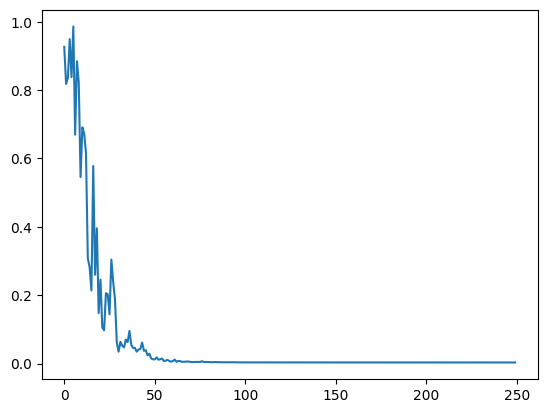

In [ ]:
log = VQLSLog([], [])
estimator_noisefree = Estimator()
sampler_noisefree = Sampler()

vqls = VQLS(estimator_noisefree, ansatz, optimizer, sampler=sampler_noisefree, callback=log.update)
vqls.solve(A,b,options={"matrix_decomposition":'optimized_pauli', 'shots':None} )

import matplotlib.pyplot as plt
plt.plot(log.values)